C:\Users\sxzxc\ANACONDA\lib\site-packages\xlsxwriter\workbook.py:338: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


Excel file saved as Processed_NLuc_multi.xlsx


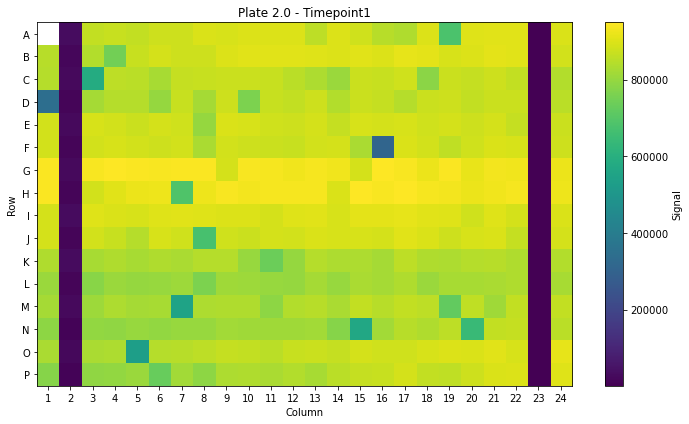

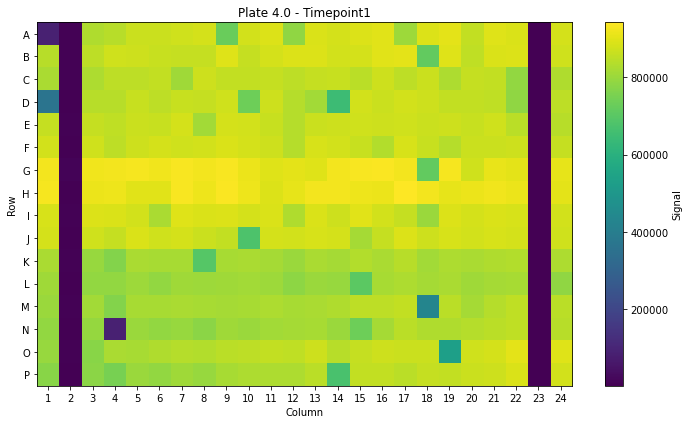

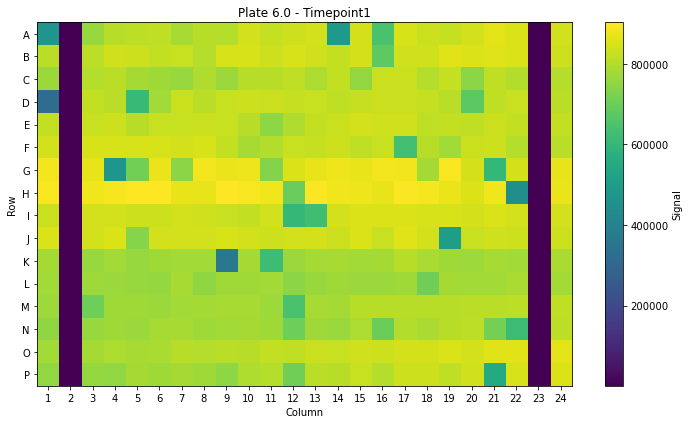

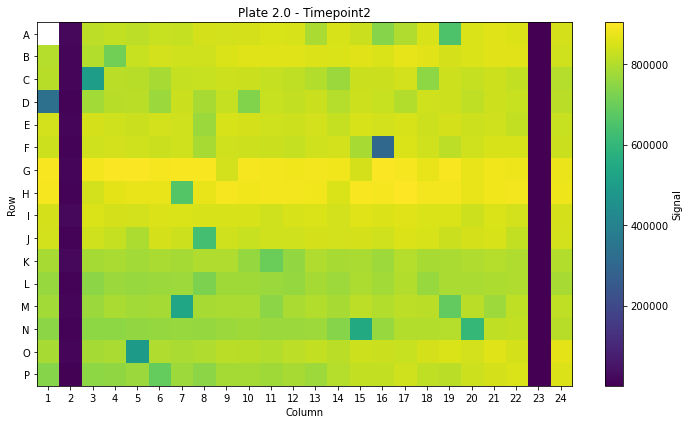

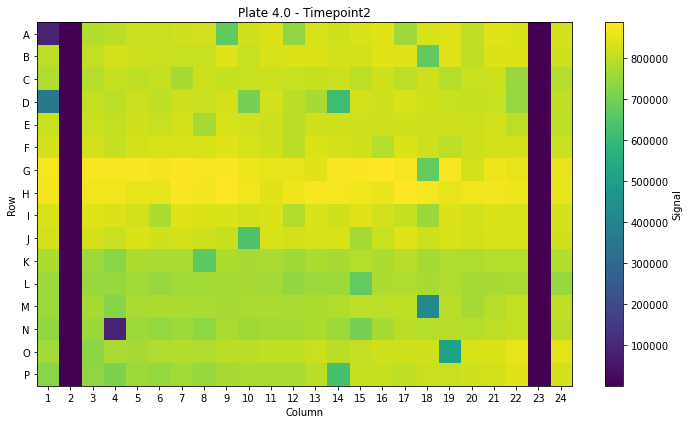

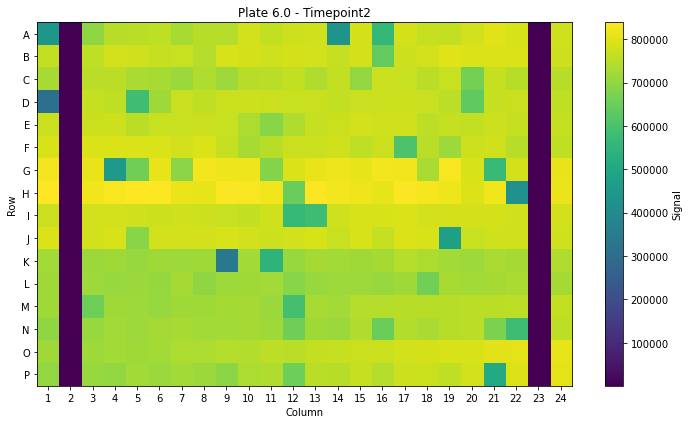

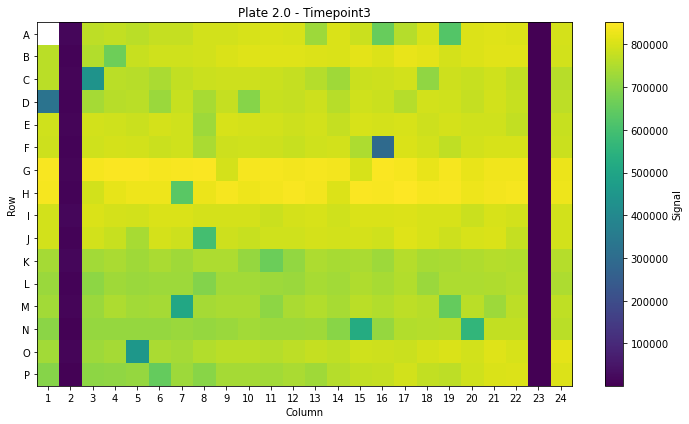

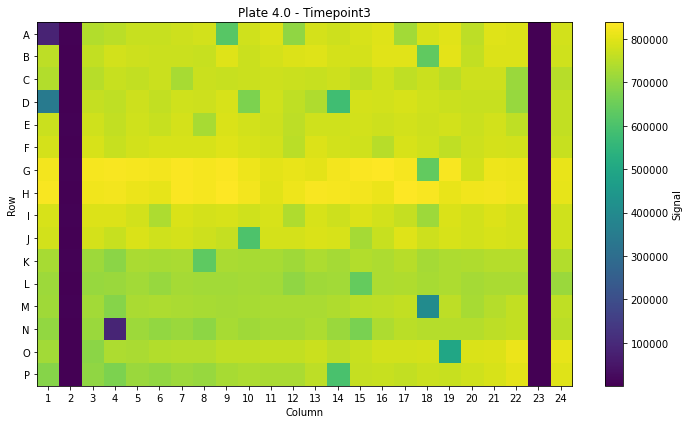

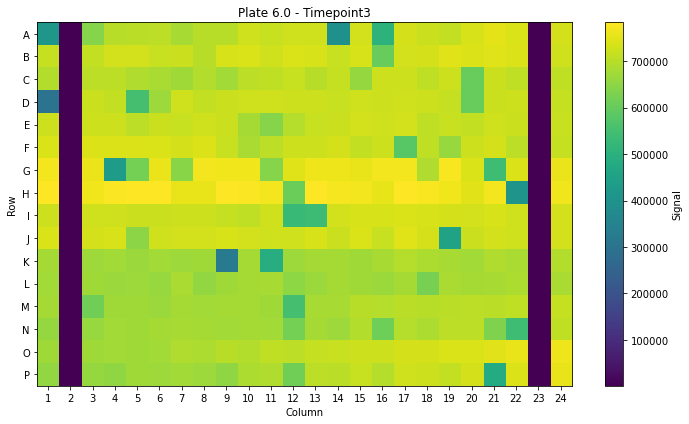

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV file. It is assumed the file has a header row.
df = pd.read_csv("NLuc.csv", skiprows=2)

# Define constants:
# Column A (index 0): Plate name.
# Column C (index 2): Well name.
# Column E (index 4): Timepoint 1 data.
# Column I (index 7): Timepoint 2 data.
# Column M (index 12): Timepoint 3 data.

# Plate layout: 384-well (16 rows A-P and 24 columns 1-24)
rows = list("ABCDEFGHIJKLMNOP")
cols = [str(i) for i in range(1, 25)]

def create_plate_df(well_names, data):
    """
    Create a DataFrame representing a 384-well plate.
    well_names: Series of well names (e.g., "A1", "B12", etc.)
    data: Series of corresponding measurements.
    Returns a DataFrame with rows A-P and columns 1-24.
    """
    plate_df = pd.DataFrame(index=rows, columns=cols)
    for well, value in zip(well_names, data):
        well = str(well).strip()
        if len(well) < 2:
            continue
        row_letter = well[0].upper()
        try:
            col_number = str(int(well[1:]))
        except:
            continue
        if row_letter in plate_df.index and col_number in plate_df.columns:
            plate_df.loc[row_letter, col_number] = value
    return plate_df

# Define timepoint mapping: sheet name -> column index for data.
timepoints = {
    "Timepoint1": 4,  # column E
    "Timepoint2": 8,  # column I
    "Timepoint3": 12  # column M
}

# Create an Excel workbook with one sheet per timepoint.
output_filename = "Processed_NLuc_multi.xlsx"
with pd.ExcelWriter(output_filename, engine="xlsxwriter") as writer:
    # For each timepoint, create a sheet with data blocks for each plate.
    for tp_name, col_idx in timepoints.items():
        # Create a new worksheet for this timepoint.
        worksheet = writer.book.add_worksheet(tp_name)
        writer.sheets[tp_name] = worksheet
        row_offset = 0
        # Group the data by plate (column A, index 0)
        for plate_name, group in df.groupby(df.iloc[:, 0]):
            # Write the plate name as a header.
            worksheet.write(row_offset, 0, f"Plate: {plate_name}")
            row_offset += 1
            # Generate the 384-well plate DataFrame using column C (well names) and the appropriate timepoint data.
            plate_df = create_plate_df(group.iloc[:, 2], group.iloc[:, col_idx])
            # Write the plate DataFrame into the sheet starting at the current row.
            plate_df.to_excel(writer, sheet_name=tp_name, startrow=row_offset, startcol=0)
            # Update row_offset: 16 rows for the plate plus one header row from to_excel, plus a couple of blank rows.
            row_offset += plate_df.shape[0] + 1 + 2
    writer.save()

print("Excel file saved as", output_filename)

# Function to plot a heatmap for a given plate DataFrame.
def plot_heatmap(plate_df, title):
    plt.figure(figsize=(10, 6))
    # Convert the DataFrame to a float array (non-numeric cells become NaN)
    data_array = plate_df.astype(float).values
    im = plt.imshow(data_array, aspect='auto', cmap='viridis', origin='upper')
    plt.title(title)
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.xticks(ticks=np.arange(len(cols)), labels=cols)
    plt.yticks(ticks=np.arange(len(rows)), labels=rows)
    plt.colorbar(im, label="Signal")
    plt.tight_layout()
    plt.show()

# Generate heatmaps for each plate at each timepoint.
for tp_name, col_idx in timepoints.items():
    for plate_name, group in df.groupby(df.iloc[:, 0]):
        plate_df = create_plate_df(group.iloc[:, 2], group.iloc[:, col_idx])
        plot_heatmap(plate_df, f"Plate {plate_name} - {tp_name}")


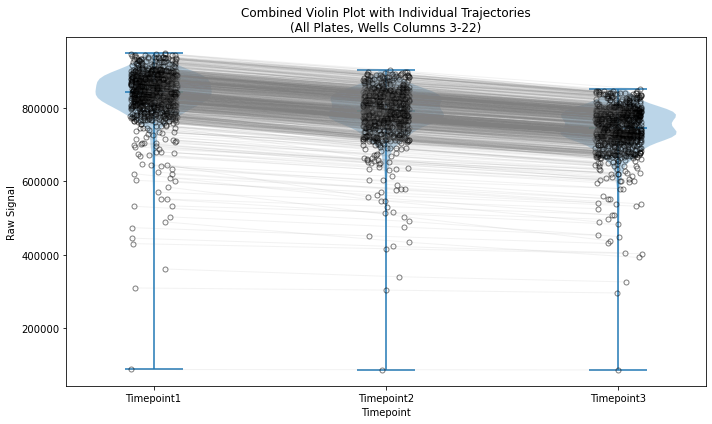

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def process_sheet(sheet_name, timepoint_label, excel_file):
    """
    Process one sheet of the processed Excel file.
    Each plate block starts with a row whose first cell contains "Plate: <plate_name>".
    The next row is the header row (with well column numbers), followed by 16 rows of data.
    This function extracts the data only for columns corresponding to well numbers 3–22.
    Returns a DataFrame with columns: Plate, Well, and a column for the given timepoint.
    """
    df_sheet = pd.read_excel(excel_file, sheet_name=sheet_name, header=None)
    records = []
    i = 0
    while i < len(df_sheet):
        cell_val = df_sheet.iloc[i, 0]
        if isinstance(cell_val, str) and cell_val.startswith("Plate:"):
            # Extract the plate name.
            plate_name = cell_val.split("Plate:")[-1].strip()
            # Next row is the header row.
            header_row = df_sheet.iloc[i+1]
            # Identify columns (in this block) that correspond to well numbers 3 to 22.
            col_indices = []
            for col in range(1, len(header_row)):
                try:
                    col_val = header_row[col]
                    col_num = int(col_val)
                    if 3 <= col_num <= 22:
                        col_indices.append(col)
                except:
                    pass
            # Table data are in the next 16 rows.
            table_start = i + 2
            table_end = table_start + 16
            for j in range(table_start, min(table_end, len(df_sheet))):
                row_label = df_sheet.iloc[j, 0]  # Expected to be the row letter (A, B, etc.)
                if pd.isnull(row_label):
                    continue
                for idx in col_indices:
                    try:
                        col_val = header_row[idx]  # Well column number.
                        well = f"{row_label}{col_val}"
                    except:
                        continue
                    value = df_sheet.iloc[j, idx]
                    records.append({
                        "Plate": plate_name,
                        "Well": well,
                        timepoint_label: value
                    })
            # Move pointer past this block.
            i = table_end
        else:
            i += 1
    return pd.DataFrame(records)

# Path to the processed Excel file.
excel_file = "Processed_NLuc_multi.xlsx"

# Process each sheet (Timepoint1, Timepoint2, Timepoint3).
df_tp1 = process_sheet("Timepoint1", "tp1", excel_file)
df_tp2 = process_sheet("Timepoint2", "tp2", excel_file)
df_tp3 = process_sheet("Timepoint3", "tp3", excel_file)

# Merge the DataFrames on Plate and Well.
merged_df = pd.merge(df_tp1, df_tp2, on=["Plate", "Well"], how="outer")
merged_df = pd.merge(merged_df, df_tp3, on=["Plate", "Well"], how="outer")

# Convert timepoint columns to numeric.
merged_df["tp1"] = pd.to_numeric(merged_df["tp1"], errors="coerce")
merged_df["tp2"] = pd.to_numeric(merged_df["tp2"], errors="coerce")
merged_df["tp3"] = pd.to_numeric(merged_df["tp3"], errors="coerce")

# Create the combined violin plot.
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for violin plots: one array per timepoint.
data_to_plot = [
    merged_df["tp1"].dropna().values.astype(float),
    merged_df["tp2"].dropna().values.astype(float),
    merged_df["tp3"].dropna().values.astype(float)
]
ax.violinplot(data_to_plot, positions=[1, 2, 3], showmedians=True)

# For each well (identified by Plate and Well), if all three timepoints are available,
# plot a connecting line with open circles at slightly jittered x positions.
np.random.seed(42)  # For reproducibility of jitter
for _, row in merged_df.iterrows():
    if pd.notnull(row["tp1"]) and pd.notnull(row["tp2"]) and pd.notnull(row["tp3"]):
        base_x = np.array([1, 2, 3])
        # Add a small random jitter to each x coordinate.
        jitter = np.random.uniform(-0.1, 0.1, size=3)
        x_jitter = base_x + jitter
        y_values = np.array([row["tp1"], row["tp2"], row["tp3"]])
        # Plot the connecting line with 90% transparency.
        ax.plot(x_jitter, y_values, color='gray', alpha=0.1, linestyle='-', linewidth=1)
        # Plot the data points as open circles.
        ax.plot(x_jitter, y_values, linestyle='none', marker='o', markerfacecolor='none', 
                markeredgecolor='black', alpha=0.5, markersize=5)

# Label x-axis and set tick positions.
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["Timepoint1", "Timepoint2", "Timepoint3"])
ax.set_xlabel("Timepoint")
ax.set_ylabel("Raw Signal")
ax.set_title("Combined Violin Plot with Individual Trajectories\n(All Plates, Wells Columns 3-22)")

plt.tight_layout()
plt.show()


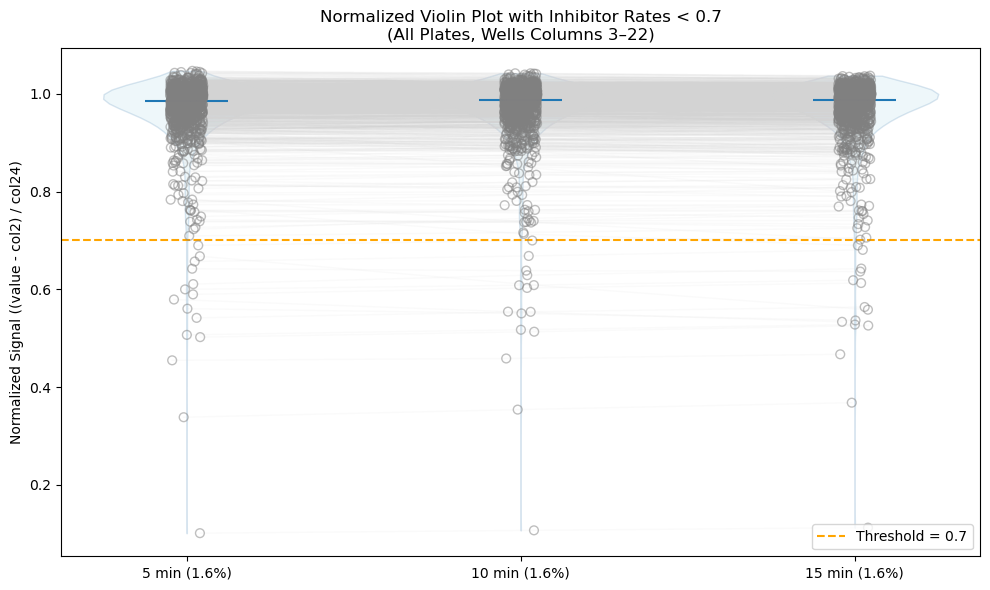

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the Excel file
file_path = "Processed_NLuc_multi.xlsx"

# Function to extract and normalize data per sheet
def process_sheet_custom_normalized(sheet_name, timepoint_label, excel_file):
    df_sheet = pd.read_excel(excel_file, sheet_name=sheet_name, header=None)
    records = []
    i = 0
    while i < len(df_sheet):
        cell_val = df_sheet.iloc[i, 0]
        if isinstance(cell_val, str) and cell_val.startswith("Plate:"):
            plate_name = cell_val.split("Plate:")[-1].strip()
            header_row = df_sheet.iloc[i+1]
            col_indices = []
            idx_col2 = None
            idx_col24 = None
            for col in range(1, len(header_row)):
                try:
                    col_val = int(header_row[col])
                    if col_val == 2:
                        idx_col2 = col
                    elif col_val == 24:
                        idx_col24 = col
                    elif 3 <= col_val <= 22:
                        col_indices.append((col, col_val))
                except:
                    continue
            if idx_col2 is None or idx_col24 is None:
                i += 1
                continue
            table_start = i + 2
            table_end = table_start + 16
            for j in range(table_start, min(table_end, len(df_sheet))):
                row_label = df_sheet.iloc[j, 0]
                if pd.isnull(row_label):
                    continue
                base = df_sheet.iloc[j, idx_col2]
                scale = df_sheet.iloc[j, idx_col24]
                if pd.isnull(base) or pd.isnull(scale) or scale == 0:
                    continue
                for col_idx, col_val in col_indices:
                    value = df_sheet.iloc[j, col_idx]
                    if pd.notnull(value):
                        normalized = (value - base) / scale
                        records.append({
                            "Plate": plate_name,
                            "Well": f"{row_label}{col_val}",
                            timepoint_label: normalized
                        })
            i = table_end
        else:
            i += 1
    return pd.DataFrame(records)

# Process and merge all timepoints
df_tp1 = process_sheet_custom_normalized("Timepoint1", "tp1", file_path)
df_tp2 = process_sheet_custom_normalized("Timepoint2", "tp2", file_path)
df_tp3 = process_sheet_custom_normalized("Timepoint3", "tp3", file_path)

merged_df = pd.merge(df_tp1, df_tp2, on=["Plate", "Well"], how="outer")
merged_df = pd.merge(merged_df, df_tp3, on=["Plate", "Well"], how="outer")
merged_df = merged_df.dropna(subset=["tp1", "tp2", "tp3"])

# Prepare data for plotting
tp1_vals = merged_df["tp1"].values
tp2_vals = merged_df["tp2"].values
tp3_vals = merged_df["tp3"].values
data_to_plot = [tp1_vals, tp2_vals, tp3_vals]

# Calculate inhibitor rate with threshold < 0.7
threshold = 0.7
inhibitor_rates = [
    (tp1_vals < threshold).sum() / len(tp1_vals) * 100,
    (tp2_vals < threshold).sum() / len(tp2_vals) * 100,
    (tp3_vals < threshold).sum() / len(tp3_vals) * 100
]

# Custom x-axis labels with inhibitor percentages
x_labels = [
    f"5 min ({inhibitor_rates[0]:.1f}%)",
    f"10 min ({inhibitor_rates[1]:.1f}%)",
    f"15 min ({inhibitor_rates[2]:.1f}%)"
]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
vparts = ax.violinplot(data_to_plot, positions=[1, 2, 3], showmeans=False, showmedians=True, showextrema=False)

# Style violins
for pc in vparts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_edgecolor('steelblue')
    pc.set_alpha(0.2)

# Dashed threshold line
ax.axhline(y=threshold, color='orange', linestyle='--', linewidth=1.5, label='Threshold = 0.7')

# Jittered points and connection lines
np.random.seed(42)
for _, row in merged_df.iterrows():
    jitter = np.random.uniform(-0.05, 0.05)
    x = np.array([1, 2, 3]) + jitter
    y = np.array([row["tp1"], row["tp2"], row["tp3"]])
    ax.plot(x, y, color='lightgray', alpha=0.1, linewidth=1, zorder=1)
    ax.scatter(x, y, facecolors='none', edgecolors='gray', s=40, zorder=2, alpha=0.5)

# Final touches
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(x_labels)
ax.set_ylabel("Normalized Signal ((value - col2) / col24)")
ax.set_title("Normalized Violin Plot with Inhibitor Rates < 0.7\n(All Plates, Wells Columns 3–22)")
ax.legend()

plt.tight_layout()
plt.show()